In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Notebooks/tmp/"
DATA_PATH = "/content/drive/MyDrive/Notebooks/tmp/"

In [ ]:
import numpy as np
import torch
import math
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
import time
import copy
from os import path
import sys



dtype=torch.float


# %matplotlib inline
plt. close('all')

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#### Solve the SE (For ISW and given eigenvalues)
$$
\left( -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + V(x) \right) \psi_n(x) = E_n \psi_n(x)
$$
This is the famous *Schrödinger equation*.

Define a new activation function; Not used in this example

In [ ]:
# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)


Define some helper functions

In [ ]:
# Calculate the derivatice with auto-differention
def dfx(x,f):
    return grad([f], [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def perturbPoints(grid,t0,tf,sig=0.5):
#   stochastic perturbation of the evaluation points
#   force t[0]=t0  & force points to be in the t-interval
    delta_t = grid[1] - grid[0]
    noise = delta_t * torch.randn_like(grid)*sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0]=t0 - t.data[t<t0]
    t.data[t>tf]=2*tf - t.data[t>tf]
    # t.data[0] = torch.ones(1,1)*t0
    t.requires_grad = False
    t=t.sort(dim=0)[0]
    return t


def parametricSolutions(t, nn, X0):
    # parametric solutions
    t0,L0, L1, f0 = X0[0],X0[1], X0[2],X0[6]
    N1  = nn(t)
    dt =t-t0
#### THERE ARE TWO PARAMETRIC SOLUTIONS. Uncomment f=dt
    f = (1-torch.exp(-(dt-L0)))*(1-torch.exp((dt-L1)))
   #  f=dt
    x_hat  = f0  + f*N1
    return x_hat



def Eqs_Loss(t,x1, X0,n_train):
    # Define the loss function by  Eqs.
    xddot = dfx(t,dfx(t,x1))
    L0,L1= X0[1],X0[2]
    lam = X0[3]
    m = X0[4]
    hbar = X0[5]
    f1  = (hbar**2) * xddot / (2*m) +  lam*x1
    norm=torch.trapz(x1.pow(2), t, dim=0)
    # L  = (f1.pow(2)).mean()  + 1/( (x1.pow(2)).mean() + (1e-6) )
    Ldrive  = (f1.pow(2)).mean()
    Lreg=0.01*((1-norm).pow(2))
    #Lreg = (Ldrive/(1-norm).pow(2)).detach() * (1-norm).pow(2)
    #or .data instead of detach
    Ltot=Ldrive+Lreg
    return Ltot,Ldrive,Lreg


Network architecture

In [ ]:
# A two hidden layer NN, 1 input & 1 output
class odeNet(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(odeNet,self).__init__()

        # Define the Activation
        self.actF = torch.nn.Sigmoid()
#         self.actF = mySin()

        # define layers
        self.Lin_1   = torch.nn.Linear(1, D_hid)
        self.Lin_2   = torch.nn.Linear(D_hid, D_hid)
#        self.Lin_3   = torch.nn.Linear(D_hid, D_hid)
        self.Lin_out = torch.nn.Linear(D_hid, 1)

    def forward(self,t):
        # layer 1
        l = self.Lin_1(t);    h = self.actF(l)
        # layer 2
        l = self.Lin_2(h);    h = self.actF(l)
        # layer 3
#        l = self.Lin_2(h);    h = self.actF(l)
        # output layer
        netOut = self.Lin_out(h)
        return netOut


In [ ]:

# Train the NN
def run_odeNet(X0, tf, neurons, epochs, n_train,lr, PATH= "", loadWeights=False,
                    minibatch_number = 1, minLoss=1e-3):
    PATH = MODEL_PATH + PATH
    fc0 = odeNet(neurons)
    fc1 =  copy.deepcopy(fc0) # fc1 is a deepcopy of the network with the lowest training loss
    # optimizer
    betas = [0.999, 0.9999]

    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)
    Loss_history = [];     Llim =  1
    LossDrive_history = [];
    LossReg_history = [];

    t0=X0[0];
    grid = torch.linspace(t0, tf, n_train).reshape(-1,1)




## LOADING WEIGHTS PART if PATH file exists and loadWeights=True
    if path.exists(PATH) and loadWeights==True:
        checkpoint = torch.load(PATH)
        fc0.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        tt = checkpoint['epoch']
        Ltot = checkpoint['loss']
        fc0.train(); # or model.eval


## TRAINING ITERATION
    TeP0 = time.time()
    for tt in range(epochs):
# Perturbing the evaluation points & forcing t[0]=t0
        # t=perturbPoints(grid,t0,tf,sig=.03*tf)
        t=perturbPoints(grid,t0,tf,sig= 0.3*tf)
# BATCHING
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        t_b = t
        t_b.requires_grad = True
        loss=0.0
        lossDrive=0.0
        lossReg=0.0
        for nbatch in range(minibatch_number):
# batch time set
            t_mb = t_b[batch_start:batch_end]
#  Network solutions
            x = parametricSolutions(t_mb,fc0,X0)
# LOSS
#  Loss function defined by Hamilton Eqs. (symplectic): Writing explicitely the Eqs (faster)
            Ltot,Ldrive,Lreg = Eqs_Loss(t_mb,x, X0, n_train)


#  Loss function defined by Hamilton Eqs. (symplectic): Calculating with auto-diff the Eqs (slower)
#             Ltot = hamEqs_Loss_byH(t_mb,x,y,px,py,lam)


# OPTIMIZER
            Ltot.backward(retain_graph=False); #True
            optimizer.step();
            loss += Ltot.data.numpy()
            lossDrive += Ldrive.data.numpy()
            lossReg += Lreg.data.numpy()

            optimizer.zero_grad()

            batch_start +=batch_size
            batch_end +=batch_size

# keep the loss function history
        Loss_history.append(loss)
        LossDrive_history.append(lossDrive)
        LossReg_history.append(lossReg)


#Keep the best model (lowest loss) by using a deep copy
        if  tt > 0.8*epochs  and Ltot < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=Ltot

# break the training after a thresold of accuracy
        if Ltot < minLoss :
            fc1 =  copy.deepcopy(fc0)
            print('Reach minimum requested loss')
            break



    TePf = time.time()
    runTime = TePf - TeP0


    torch.save({
    'epoch': tt,
    'model_state_dict': fc1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': Ltot,
    }, PATH)

    return fc1, Loss_history, runTime, LossDrive_history, LossReg_history


In [ ]:

def trainModel(X0, t_max, neurons, epochs, n_train, lr,  loadWeights=True, minLoss=1e-6, showLoss=True, PATH =""):
    model,loss,runTime, lossDrive, lossReg = run_odeNet(X0, t_max, neurons, epochs, n_train,lr, PATH,  loadWeights=loadWeights, minLoss=minLoss, minibatch_number=1)

    np.savetxt('loss.txt',loss)

    if showLoss==True :
        print('Training time (minutes):', runTime/60)
        print('Training Loss: ',  loss[-1] )
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(18, 6))
        fig.suptitle('Loss')
        ax1.loglog(loss,'-b',alpha=0.975, label="Total");
        ax2.loglog(lossDrive,'-r',alpha=0.975, label="Drive");
        ax3.loglog(lossReg,'-g',alpha=0.975, label="Regularization");
        ax1.set_ylabel('Loss');ax1.set_xlabel('t')
        ax2.set_ylabel('Loss');ax2.set_xlabel('t')
        ax3.set_ylabel('Loss');ax3.set_xlabel('t')
        ax1.set_title('Total Loss')
        ax2.set_title('Driving Loss')
        ax3.set_title('Regularization Loss')

        # plt.savefig('HHsystem/HenonHeiles_loss.png')
        plt.savefig('simple_expDE_loss.png')


def loadModel(PATH ):
    PATH = MODEL_PATH + PATH
    if path.exists(PATH):
        fc0 = odeNet(neurons)
        checkpoint = torch.load(PATH)
        fc0.load_state_dict(checkpoint['model_state_dict'])
        fc0.train(); # or model.eval
    else:
        print('Warning: There is not any trained model. Terminate')
        sys.exit()

    return fc0


**FIRST EIGENVECTOR (n=1)**

Training time (minutes): 0.1598610281944275
Training Loss:  [0.00173309]


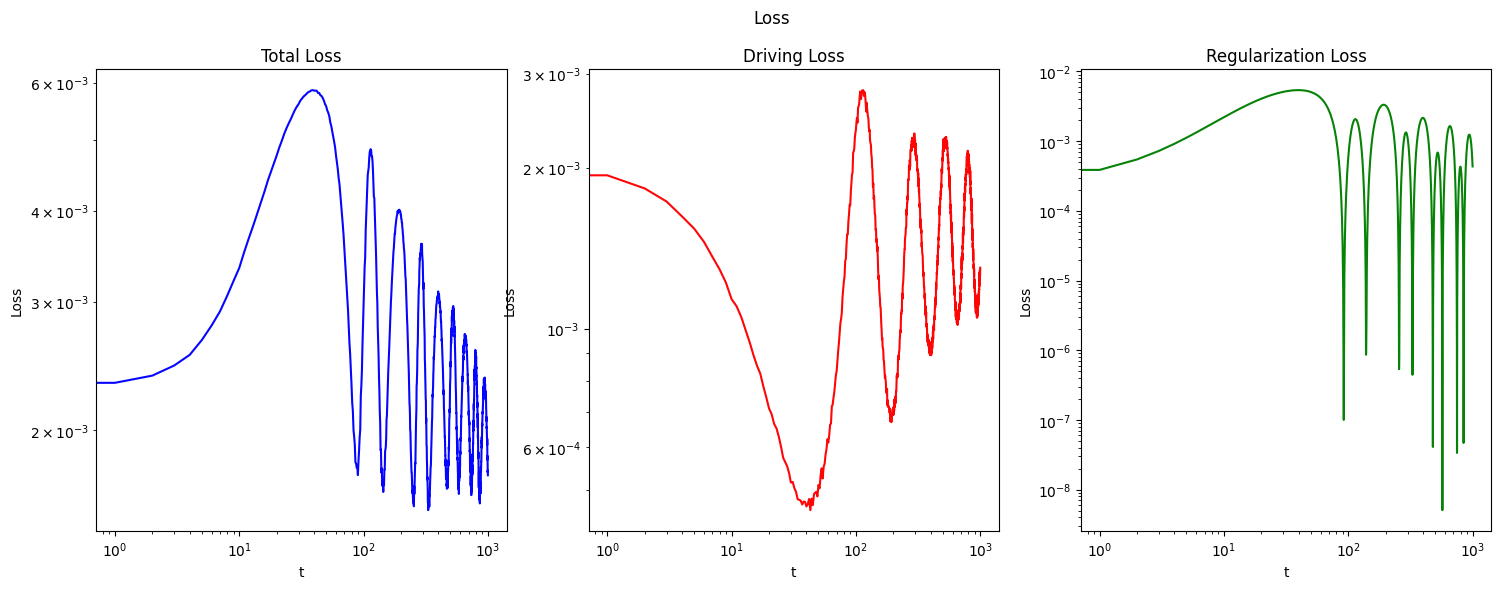

In [ ]:

# TRAIN THE NETWORK.
L0 = 0
L1 = 10
# Set the time range and the training points N
t0, t_max, N = L0, L1 , 500;
# Set the initial state. lam controls the nonlinearity
n=1
m = 1
hbar = 1
f0=0
lam= (n**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))
X0 = [t0, L0, L1, lam, m, hbar,f0]



# Here, we use one mini-batch. NO significant different in using more
n_train, neurons, epochs, lr = N, 80, int( 1e3 ), 8e-3
trainModel(X0, t_max, neurons, epochs, n_train, lr, PATH="isw_bound_1", loadWeights=True, minLoss=1e-8, showLoss=True)
model1 = loadModel("isw_bound_1")


Test the predictions

In [ ]:
nTest = N ; t_max_test = 1.0*t_max
tTest = torch.linspace(t0,t_max_test,nTest)

tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()


xTest1=parametricSolutions(tTest,model1,X0)
xdotTest1=dfx(tTest,xTest1)
xddotTest1=dfx(tTest, dfx(tTest,xTest1))

xTest1=xTest1.data.numpy()
xdotTest1=xdotTest1.data.numpy()
xddotTest1=xddotTest1.data.numpy()


Ground Truth solution

In [ ]:
x_exact1 = -math.sqrt(2/(L1-L0))*np.sin(1*math.pi*t_net/(L1-L0))
xdot_exact1 =-(1*math.pi/(L1-L0)) * math.sqrt(2/(L1-L0))*np.cos(1*math.pi*t_net/(L1-L0))
xddot_exact1 = +(1*math.pi/(L1-L0))**2 * math.sqrt(2/(L1-L0))*np.sin(1*math.pi*t_net/(L1-L0))



Make some plots

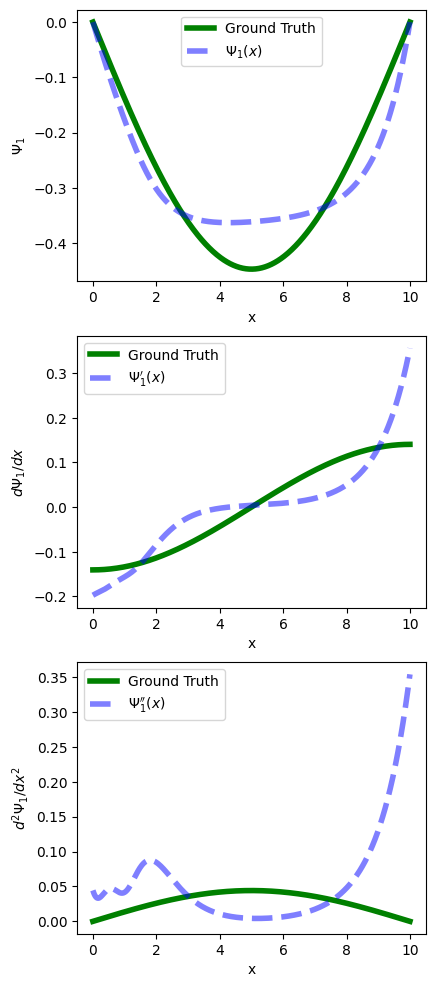

In [ ]:
################
# Make the plots
#################

lineW = 4 # Line thickness
plt.figure(figsize=(4.5,12))
plt.subplot(3,1,1)
plt.plot(t_net, x_exact1,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xTest1,'--b', label=r'$\Psi_1(x)$',linewidth=lineW, alpha=.5);
plt.ylabel(r'$\Psi_1$');plt.xlabel('x')
plt.legend()


plt.subplot(3,1,2)
plt.plot(t_net, xdot_exact1,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xdotTest1,'--b', label=r"$\Psi_1'(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d \Psi_1/ dx$");plt.xlabel('x')
plt.legend()


plt.subplot(3,1,3)
plt.plot(t_net, xddot_exact1,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xddotTest1,'--b', label=r"$\Psi_1''(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d^2 \Psi_1/ dx^2$");plt.xlabel('x')
plt.legend()




# #plt.savefig('../results/HenonHeiles_trajectories.png')
plt.savefig(DATA_PATH + 'isw_bound_1.png')


**SECOND EIGENVECTOR (n=2)**

Reach minimum requested loss
Training time (minutes): 0.16958634853363036
Training Loss:  [9.893581e-07]


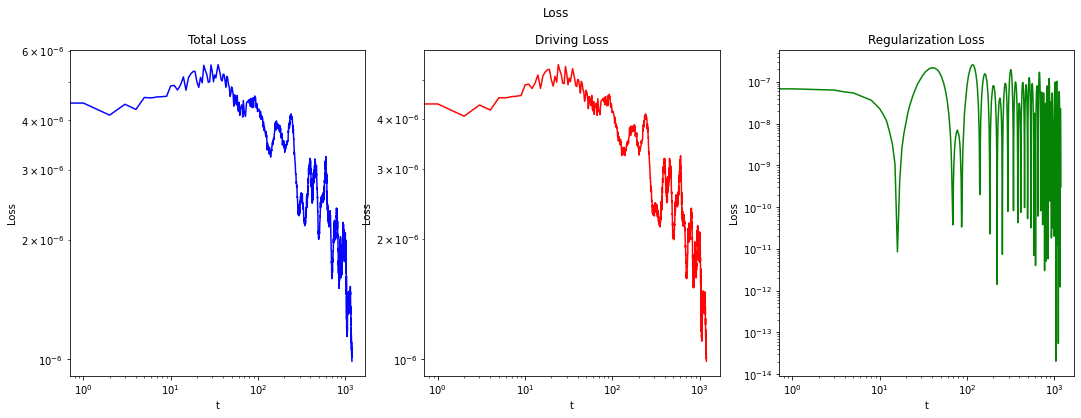

In [ ]:

# TRAIN THE NETWORK.
L0 = 0
L1 = 10
# Set the time range and the training points N
t0, t_max, N = L0, L1 , 500;
# Set the initial state. lam controls the nonlinearity
n=2
m = 1
hbar = 1
f0=0
lam= (n**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))
X0 = [t0, L0, L1, lam, m, hbar,f0]



# Here, we use one mini-batch. NO significant different in using more
n_train, neurons, epochs, lr = N, 80, int( 1e4 ), 8e-3
trainModel(X0, t_max, neurons, epochs, n_train, lr, PATH="isw_bound_2", loadWeights=True, minLoss=1e-6, showLoss=True)
model2 = loadModel("isw_bound_2")


In [ ]:
nTest = N ; t_max_test = 1.0*t_max
tTest = torch.linspace(t0,t_max_test,nTest)

tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()


xTest2=parametricSolutions(tTest,model2,X0)
xdotTest2=dfx(tTest,xTest2)
xddotTest2=dfx(tTest, dfx(tTest,xTest2))

xTest2=xTest2.data.numpy()
xdotTest2=xdotTest2.data.numpy()
xddotTest2=xddotTest2.data.numpy()


In [ ]:
x_exact2 = -math.sqrt(2/(L1-L0))*np.sin(2*math.pi*t_net/(L1-L0))
xdot_exact2 =-(2*math.pi/(L1-L0)) * math.sqrt(2/(L1-L0))*np.cos(2*math.pi*t_net/(L1-L0))
xddot_exact2 = (2*math.pi/(L1-L0))**2 * math.sqrt(2/(L1-L0))*np.sin(2*math.pi*t_net/(L1-L0))


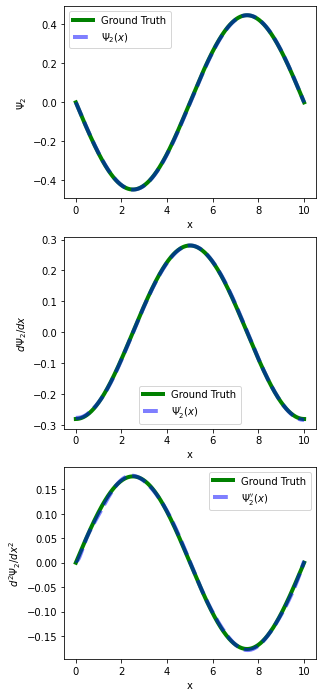

In [ ]:
################
# Make the plots
#################

lineW = 4 # Line thickness
plt.figure(figsize=(4.5,12))
plt.subplot(3,1,1)
plt.plot(t_net, x_exact2,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xTest2,'--b', label=r'$\Psi_2(x)$',linewidth=lineW, alpha=.5);
plt.ylabel(r'$\Psi_2$');plt.xlabel('x')
plt.legend()


plt.subplot(3,1,2)
plt.plot(t_net, xdot_exact2,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xdotTest2,'--b', label=r"$\Psi_2'(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d \Psi_2/ dx$");plt.xlabel('x')
plt.legend()


plt.subplot(3,1,3)
plt.plot(t_net, xddot_exact2,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xddotTest2,'--b', label=r"$\Psi_2''(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d^2 \Psi_2/ dx^2$");plt.xlabel('x')
plt.legend()




# #plt.savefig('../results/HenonHeiles_trajectories.png')
plt.savefig(DATA_PATH + 'isw_bound_2.png')


**THIRD EIGENFUNCTION (n=3)**

Reach minimum requested loss
Training time (minutes): 0.024045856793721516
Training Loss:  [9.934206e-07]


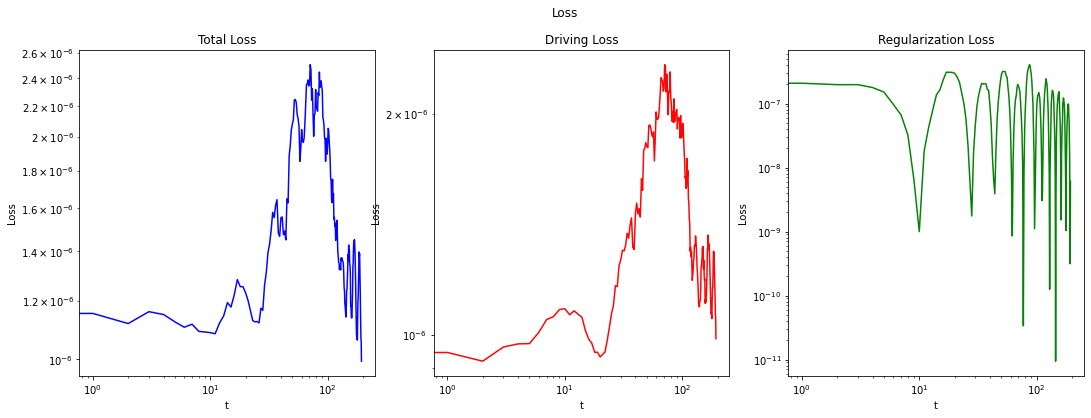

In [ ]:

# TRAIN THE NETWORK.
L0 = 0
L1 = 10
# Set the time range and the training points N
t0, t_max, N = L0, L1 , 500;
# Set the initial state. lam controls the nonlinearity
n=3
m = 1
hbar = 1
f0=0
lam= (n**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))
X0 = [t0, L0, L1, lam, m, hbar,f0]



# Here, we use one mini-batch. NO significant different in using more
n_train, neurons, epochs, lr = N, 80, int( 1e4 ), 8e-3
trainModel(X0, t_max, neurons, epochs, n_train, lr, PATH="isw_bound_3", loadWeights=True, minLoss=1e-6, showLoss=True)
model3 = loadModel("isw_bound_3")


In [ ]:
nTest = N ; t_max_test = 1.0*t_max
tTest = torch.linspace(t0,t_max_test,nTest)

tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()


xTest3=parametricSolutions(tTest,model3,X0)
xdotTest3=dfx(tTest,xTest3)
xddotTest3=dfx(tTest, dfx(tTest,xTest3))

xTest3=xTest3.data.numpy()
xdotTest3=xdotTest3.data.numpy()
xddotTest3=xddotTest3.data.numpy()


In [ ]:
x_exact3 = math.sqrt(2/(L1-L0))*np.sin(3*math.pi*t_net/(L1-L0))
xdot_exact3 =(3*math.pi/(L1-L0)) * math.sqrt(2/(L1-L0))*np.cos(3*math.pi*t_net/(L1-L0))
xddot_exact3 = -(3*math.pi/(L1-L0))**2 * math.sqrt(2/(L1-L0))*np.sin(3*math.pi*t_net/(L1-L0))


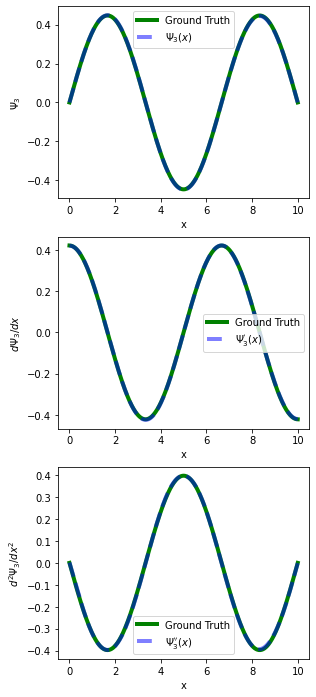

In [ ]:
################
# Make the plots
#################

lineW = 4 # Line thickness
plt.figure(figsize=(4.5,12))
plt.subplot(3,1,1)
plt.plot(t_net, x_exact3,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xTest3,'--b', label=r'$\Psi_3(x)$',linewidth=lineW, alpha=.5);
plt.ylabel(r'$\Psi_3$');plt.xlabel('x')
plt.legend()


plt.subplot(3,1,2)
plt.plot(t_net, xdot_exact3,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xdotTest3,'--b', label=r"$\Psi_3'(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d \Psi_3/ dx$");plt.xlabel('x')
plt.legend()


plt.subplot(3,1,3)
plt.plot(t_net, xddot_exact3,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xddotTest3,'--b', label=r"$\Psi_3''(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d^2 \Psi_3/ dx^2$");plt.xlabel('x')
plt.legend()




# #plt.savefig('../results/HenonHeiles_trajectories.png')
plt.savefig(DATA_PATH + 'isw_bound_3.png')


**FOURTH EIGENFUNCTION (n=4)**

Reach minimum requested loss
Training time (minutes): 0.007821698983510336
Training Loss:  [9.955054e-07]


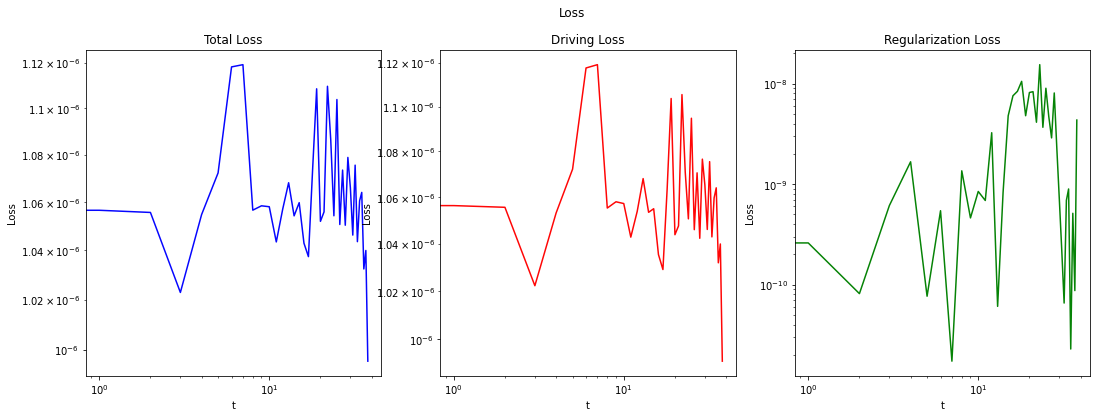

In [ ]:

# TRAIN THE NETWORK.
L0 = 0
L1 = 10
# Set the time range and the training points N
t0, t_max, N = L0, L1 , 500;
# Set the initial state. lam controls the nonlinearity
n=4
m = 1
hbar = 1
f0=0
lam= (n**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))
X0 = [t0, L0, L1, lam, m, hbar,f0]



# Here, we use one mini-batch. NO significant different in using more
n_train, neurons, epochs, lr = N, 80, int( 1e4 ), 8e-3
trainModel(X0, t_max, neurons, epochs, n_train, lr, PATH="isw_bound_4", loadWeights=True, minLoss=1e-6, showLoss=True)
model4 = loadModel("isw_bound_4")


In [ ]:
nTest = N ; t_max_test = 1.0*t_max
tTest = torch.linspace(t0,t_max_test,nTest)

tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()


xTest4=parametricSolutions(tTest,model4,X0)
xdotTest4=dfx(tTest,xTest4)
xddotTest4=dfx(tTest, dfx(tTest,xTest4))

xTest4=xTest4.data.numpy()
xdotTest4=xdotTest4.data.numpy()
xddotTest4=xddotTest4.data.numpy()


In [ ]:
x_exact4 = -math.sqrt(2/(L1-L0))*np.sin(4*math.pi*t_net/(L1-L0))
xdot_exact4 =-(4*math.pi/(L1-L0)) * math.sqrt(2/(L1-L0))*np.cos(4*math.pi*t_net/(L1-L0))
xddot_exact4 = (4*math.pi/(L1-L0))**2 * math.sqrt(2/(L1-L0))*np.sin(4*math.pi*t_net/(L1-L0))


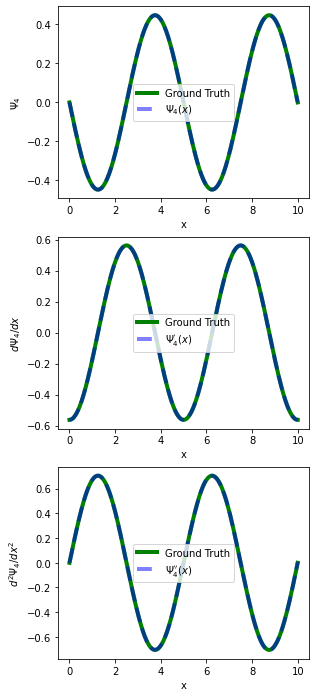

In [ ]:
################
# Make the plots
#################

lineW = 4 # Line thickness
plt.figure(figsize=(4.5,12))
plt.subplot(3,1,1)
plt.plot(t_net, x_exact4,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xTest4,'--b', label=r'$\Psi_4(x)$',linewidth=lineW, alpha=.5);
plt.ylabel(r'$\Psi_4$');plt.xlabel('x')
plt.legend()


plt.subplot(3,1,2)
plt.plot(t_net, xdot_exact4,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xdotTest4,'--b', label=r"$\Psi_4'(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d \Psi_4/ dx$");plt.xlabel('x')
plt.legend()


plt.subplot(3,1,3)
plt.plot(t_net, xddot_exact4,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xddotTest4,'--b', label=r"$\Psi_4''(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d^2 \Psi_4/ dx^2$");plt.xlabel('x')
plt.legend()




# #plt.savefig('../results/HenonHeiles_trajectories.png')
plt.savefig(DATA_PATH + 'isw_bound_4.png')


**FIFTH EIGENFUNCTION (n=5)**

Reach minimum requested loss
Training time (minutes): 1.0666677673657736
Training Loss:  [9.894445e-07]


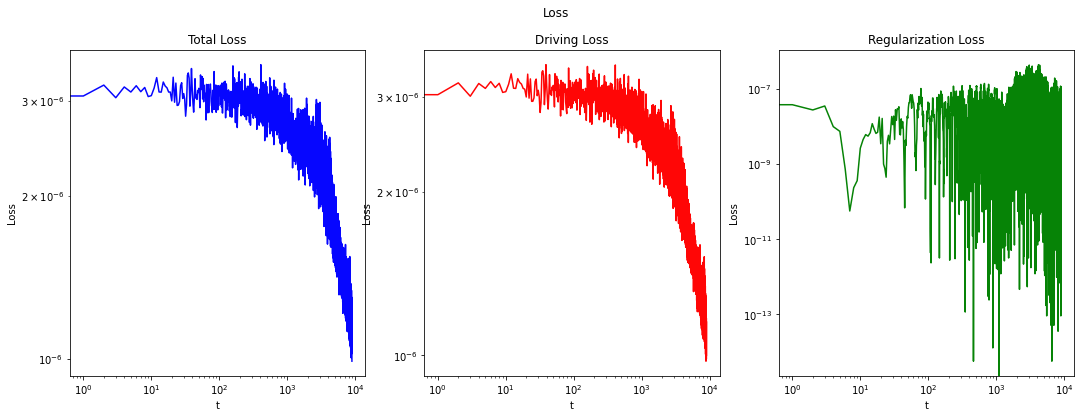

In [ ]:

# TRAIN THE NETWORK.
L0 = 0
L1 = 10
# Set the time range and the training points N
t0, t_max, N = L0, L1 , 500;
# Set the initial state. lam controls the nonlinearity
n=5
m = 1
hbar = 1
f0=0
lam= (n**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))
X0 = [t0, L0, L1, lam, m, hbar,f0]



# Here, we use one mini-batch. NO significant different in using more
n_train, neurons, epochs, lr = N, 80, int( 1e4 ), 8e-3
trainModel(X0, t_max, neurons, epochs, n_train, lr, PATH="isw_bound_5", loadWeights=True, minLoss=1e-6, showLoss=True)
model5 = loadModel("isw_bound_5")


In [ ]:
nTest = N ; t_max_test = 1.0*t_max
tTest = torch.linspace(t0,t_max_test,nTest)

tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()


xTest5=parametricSolutions(tTest,model5,X0)
xdotTest5=dfx(tTest,xTest5)
xddotTest5=dfx(tTest, dfx(tTest,xTest5))

xTest5=xTest5.data.numpy()
xdotTest5=xdotTest5.data.numpy()
xddotTest5=xddotTest5.data.numpy()


In [ ]:
x_exact5 = -math.sqrt(2/(L1-L0))*np.sin(n*math.pi*t_net/(L1-L0))
xdot_exact5 =-(n*math.pi/(L1-L0)) * math.sqrt(2/(L1-L0))*np.cos(n*math.pi*t_net/(L1-L0))
xddot_exact5 = (n*math.pi/(L1-L0))**2 * math.sqrt(2/(L1-L0))*np.sin(n*math.pi*t_net/(L1-L0))


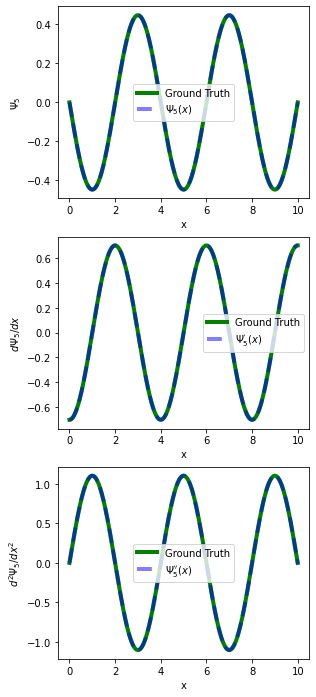

In [ ]:
################
# Make the plots
#################

lineW = 4 # Line thickness
plt.figure(figsize=(4.5,12))
plt.subplot(3,1,1)
plt.plot(t_net, x_exact5,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xTest5,'--b', label=r'$\Psi_5(x)$',linewidth=lineW, alpha=.5);
plt.ylabel(r'$\Psi_5$');plt.xlabel('x')
plt.legend()


plt.subplot(3,1,2)
plt.plot(t_net, xdot_exact5,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xdotTest5,'--b', label=r"$\Psi_5'(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d \Psi_5/ dx$");plt.xlabel('x')
plt.legend()


plt.subplot(3,1,3)
plt.plot(t_net, xddot_exact5,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xddotTest5,'--b', label=r"$\Psi_5''(x)$",linewidth=lineW, alpha=.5);
plt.ylabel(r"$d^2 \Psi_5/ dx^2$");plt.xlabel('x')
plt.legend()




# #plt.savefig('../results/HenonHeiles_trajectories.png')
plt.savefig(DATA_PATH + 'isw_bound_5.png')


Graph all

Text(0.5, 0, 'x')

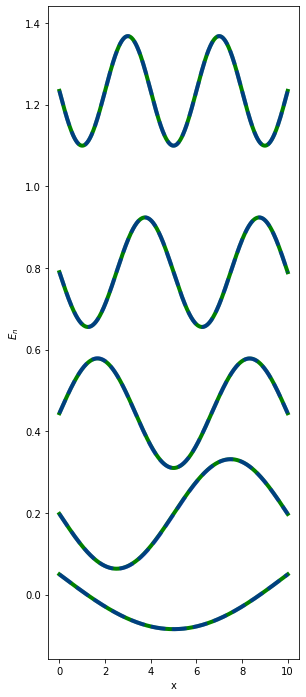

In [ ]:
plt.figure(figsize=(4.5,12))
plt.plot(t_net, (5**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+ 0.3*x_exact5,'-g', linewidth=lineW);
plt.plot(t_net, (5**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+0.3*xTest5,'--b',linewidth=lineW, alpha=.5);
plt.plot(t_net, (4**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+0.3* x_exact4,'-g', linewidth=lineW);
plt.plot(t_net, (4**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+0.3*xTest4,'--b',linewidth=lineW, alpha=.5);
plt.plot(t_net, (3**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+0.3* x_exact3,'-g', linewidth=lineW);
plt.plot(t_net, (3**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+0.3*xTest3,'--b',linewidth=lineW, alpha=.5);
plt.plot(t_net, (2**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+0.3* x_exact2,'-g', linewidth=lineW);
plt.plot(t_net, (2**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+0.3*xTest2,'--b',linewidth=lineW, alpha=.5);
plt.plot(t_net, (1**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+0.3* x_exact1,'-g', linewidth=lineW);
plt.plot(t_net, (1**2) * ((math.pi)**2) * (hbar**2) / (2*m*((L1-L0)**2))+0.3*xTest1,'--b',linewidth=lineW, alpha=.5);
plt.ylabel(r'$E_n$');plt.xlabel('x')
